In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
import torchtext
from torch import nn
from torch.autograd import Variable
import gensim

In [ ]:
# Hyper-parameters
EPOCH = 10
BATCHSIZE = 32
LR = 1e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!nvidia-smi

Thu Jul  8 11:00:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PREPROCESSING

## Prepare Data

In [ ]:
# Load data
train_iter, test_iter = torchtext.datasets.IMDB(split = ('train', 'test'))
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 29.6MB/s]


In [ ]:
# Token data and sort the data in order of token column length
train_data = [(label, tokenizer(line)) for label, line in train_iter]
train_data.sort(key = lambda x: len(x[1]))
test_data = [(label, tokenizer(line)) for label, line in test_iter]
test_data.sort(key = lambda x: len(x[1]))

In [ ]:
for i in range(10):
  print(test_data[i])

('neg', ['read', 'the', 'book', ',', 'forget', 'the', 'movie', '!'])
('neg', ['i', 'hope', 'this', 'group', 'of', 'film-makers', 'never', 're-unites', '.'])
('neg', ['primary', 'plot', '!', 'primary', 'direction', '!', 'poor', 'interpretation', '.'])
('pos', ['brilliant', 'and', 'moving', 'performances', 'by', 'tom', 'courtenay', 'and', 'peter', 'finch', '.'])
('neg', ['what', 'a', 'script', ',', 'what', 'a', 'story', ',', 'what', 'a', 'mess', '!'])
('neg', ['more', 'suspenseful', ',', 'more', 'subtle', ',', 'much', ',', 'much', 'more', 'disturbing', '.', '.', '.', '.'])
('pos', ['this', 'is', 'a', 'great', 'movie', '.', 'too', 'bad', 'it', 'is', 'not', 'available', 'on', 'home', 'video', '.'])
('pos', ['just', 'love', 'the', 'interplay', 'between', 'two', 'great', 'characters', 'of', 'stage', '&', 'screen', '-', 'veidt', '&', 'barrymore'])
('pos', ['add', 'this', 'little', 'gem', 'to', 'your', 'list', 'of', 'holiday', 'regulars', '.', 'it', 'is', 'sweet', ',', 'funny', ',', 'and', 'en

## Make Vocab


In [ ]:
def make_vocab(train_data, min_freq):
  vocab = {}
  # Make a frequency list
  for label, tokenlist in train_data:
    for token in tokenlist:
      if token not in vocab:
        vocab[token] = 1
      vocab[token] += 1
  vocablist = [('<sos>', 0), ('<eos>', 0), ('<unk>', 0),('<pad>', 0)] n
  vocabidx = {} 
  for token, freq in vocab.items():
    if freq > min_freq: # delete words with a frequency below  min_freq
      idx = len(vocablist)
      vocablist.append((token, freq))
      vocabidx[token] = idx
  vocabidx.update({'<unk>':0, '<pad>':1, '<cls>':2, '<eos>':3})
  return vocablist, vocabidx

In [ ]:
vocablist, vocabidx = make_vocab(train_data, 5) # Make vocablist 
print(vocablist) # Vocablist: Index to toke
print(vocabidx) # Vocabidx: Token to index

[('<sos>', 0), ('<eos>', 0), ('<unk>', 0), ('<pad>', 0), ('this', 75879), ('movie', 43422), ('is', 107222), ('terrible', 1632), ('but', 42411), ('it', 96025), ('has', 16760), ('some', 15724), ('good', 14814), ('effects', 2159), ('.', 327193), ('i', 87402), ('wouldn', 1055), ("'", 133858), ('t', 33928), ('rent', 687), ('one', 26102), ('even', 12589), ('on', 33741), ('dollar', 157), ('rental', 207), ('night', 2084), ('ming', 16), ('the', 335747), ('merciless', 22), ('does', 5937), ('a', 162474), ('little', 6407), ('and', 163291), ('most', 8764), ('foul', 89), ('!', 24561), ('adrian', 56), ('pasdar', 11), ('excellent', 2066), ('film', 39460), ('he', 30013), ('makes', 4194), ('fascinating', 389), ('woman', 2753), ('you', 34142), ('d', 2812), ('better', 5713), ('choose', 227), ('paul', 885), ('verhoeven', 119), ('s', 62934), ('if', 16777), ('have', 27707), ('watched', 2227), ('long', 3221), (',', 276281), ('boring', 1805), ('blasphemous', 14), ('never', 6438), ('been', 9266), ('so', 20132),

## Preprocessing


In [ ]:
# Add some special tokens to the text
def preprocessing(data, vocab_idx):
  rr = []
  for label, tokenlist in data:
    tkl = ['<cls>']
    for token in tokenlist:
      tkl.append(token if token in vocab_idx else '<unk>') 
    tkl.append('<eos>')
    rr.append((label, tkl))
  return rr

In [ ]:
train_data_prep = preprocessing(train_data, vocabidx)
test_data_prep = preprocessing(test_data, vocabidx)
for i in range(2):
  print(train_data_prep[i])
  print(test_data_prep[i])

('neg', ['<cls>', 'this', 'movie', 'is', 'terrible', 'but', 'it', 'has', 'some', 'good', 'effects', '.', '<eos>'])
('neg', ['<cls>', 'read', 'the', 'book', ',', 'forget', 'the', 'movie', '!', '<eos>'])
('neg', ['<cls>', 'i', 'wouldn', "'", 't', 'rent', 'this', 'one', 'even', 'on', 'dollar', 'rental', 'night', '.', '<eos>'])
('neg', ['<cls>', 'i', 'hope', 'this', 'group', 'of', 'film-makers', 'never', '<unk>', '.', '<eos>'])


## Make Batch

In [ ]:
# Make mini-batch
def make_batch(data, batch_size):
  bb = []
  blabel = []
  btokenlist = []
  for label, tokenlist in data:
    blabel.append(label)
    btokenlist.append(tokenlist)
    if (len(blabel) >= batch_size):
      bb.append((btokenlist, blabel))
      blabel = []
      btokenlist = []
  if len(blabel) > 0:
    bb.append((btokenlist, blabel))
  return bb

train_data_batch = make_batch(train_data_prep, BATCHSIZE)
test_data_batch = make_batch(test_data_prep, BATCHSIZE)
for i in range(2):
  print(train_data_batch[i])
  print(test_data_batch[i])

([['<cls>', 'this', 'movie', 'is', 'terrible', 'but', 'it', 'has', 'some', 'good', 'effects', '.', '<eos>'], ['<cls>', 'i', 'wouldn', "'", 't', 'rent', 'this', 'one', 'even', 'on', 'dollar', 'rental', 'night', '.', '<eos>'], ['<cls>', 'ming', 'the', 'merciless', 'does', 'a', 'little', '<unk>', 'and', 'a', 'movie', 'most', 'foul', '!', '<eos>'], ['<cls>', 'adrian', 'pasdar', 'is', 'excellent', 'is', 'this', 'film', '.', 'he', 'makes', 'a', 'fascinating', 'woman', '.', '<eos>'], ['<cls>', 'you', "'", 'd', 'better', 'choose', 'paul', 'verhoeven', "'", 's', 'even', 'if', 'you', 'have', 'watched', 'it', '.', '<eos>'], ['<cls>', 'long', ',', 'boring', ',', 'blasphemous', '.', 'never', 'have', 'i', 'been', 'so', 'glad', 'to', 'see', 'ending', 'credits', 'roll', '.', '<eos>'], ['<cls>', 'a', 'rating', 'of', '1', 'does', 'not', 'begin', 'to', 'express', 'how', 'dull', ',', 'depressing', 'and', 'relentlessly', 'bad', 'this', 'movie', 'is', '.', '<eos>'], ['<cls>', 'this', 'is', 'the', 'definitiv

## Padding

In [ ]:
def padding(data_batch):
  for tokenlists, labels in data_batch:
    maxlen = max([len(x) for x in tokenlists]) # Find the sentene have max lenght in a batch
    for tkl in tokenlists:
      for i in range(maxlen - len(tkl)):
        tkl.append('<pad>') # Add padding to align the length to the longest text
  return data_batch

train_data_padding = padding(train_data_batch)
test_data_padding = padding(test_data_batch)
for i in range(2):
  print(train_data_padding[i])
  print(test_data_padding[i])


([['<cls>', 'this', 'movie', 'is', 'terrible', 'but', 'it', 'has', 'some', 'good', 'effects', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<cls>', 'i', 'wouldn', "'", 't', 'rent', 'this', 'one', 'even', 'on', 'dollar', 'rental', 'night', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<cls>', 'ming', 'the', 'merciless', 'does', 'a', 'little', '<unk>', 'and', 'a', 'movie', 'most', 'foul', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<cls>', 'adrian', 'pasdar', 'is', 'excellent', 'is', 'this', 'film', '.', 'he', 'makes', 'a', 'fascinating', 'woman', '.

## Word to Index

In [ ]:
# Convert token to vocabulary index
def word2idx(data, vocab_idx):
  rr = []
  for tokenlists, labels in data:
    id_labels = [0 if label == 'pos' else 1 for label in labels] # Convert positive label to 1 else 0
    idx_tokenlists = []
    for tokenlist in tokenlists:
      idx_tokenlists.append([vocab_idx[token] for token in tokenlist]) # Convert all the words to index (using vocab_idx)
    rr.append((idx_tokenlists, id_labels))
  return rr 

train_data_seq = word2idx(train_data_padding, vocabidx)
test_data_seq = word2idx(test_data_padding, vocabidx)
for i in range(2):
  print(train_data_seq[i])
  print(test_data_seq[i])

([[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 15, 16, 17, 18, 19, 4, 20, 21, 22, 23, 24, 25, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 26, 27, 28, 29, 30, 31, 0, 32, 30, 5, 33, 34, 35, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 36, 37, 6, 38, 6, 4, 39, 14, 40, 41, 30, 42, 43, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 44, 17, 45, 46, 47, 48, 49, 17, 50, 21, 51, 44, 52, 53, 9, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 54, 55, 56, 55, 57, 14, 58, 52, 15, 59, 60, 61, 62, 63, 64, 65, 66, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 30, 67, 68, 69, 29, 70, 71, 62, 72, 73, 74, 55, 75, 32, 76, 77, 4, 5, 6, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 4, 6, 27, 78, 5, 79, 68, 80, 14, 81, 82, 83, 55, 8, 84, 85, 86, 87, 88, 14, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 15, 89, 17, 18, 90, 91, 15, 92, 4, 5, 60, 93, 55, 8, 15, 

## Embedding

### Glove

In [ ]:
# Download pretrained word vector 
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-07-08 11:01:39--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-08 11:01:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.10MB/s    in 2m 41s  

2021-07-08 11:04:21 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
# Unzip
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
def LoadEmbeddingModel(path_emb):
  embeddings_index = {}
  with open(path_emb, encoding='utf-8') as f:
    for line in f:
      values = line.split() 
      word = values[0]
      coefs = np.asarray(values[1:], dtype = 'float32')
      embeddings_index[word] = coefs
    f.close()
  print("Found %s word vector." % len(embeddings_index))
  return embeddings_index

In [ ]:
embeddings_index = LoadEmbeddingModel("/content/glove.6B.300d.txt")

Found 400000 word vector.


In [ ]:
# Create embedding matrix using embedding index
def EmbeddingMatrixCreater(word_index, emb_idx, emb_dim):
  embedding_matrix = np.zeros((len(word_index) + 1, emb_dim))
  for word, i in word_index.items():
    embedding_vector = emb_idx.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [ ]:
embedding_matrix_glove = EmbeddingMatrixCreater(vocabidx, embeddings_index, 300)

In [ ]:
weight_glove = torch.Tensor(embedding_matrix_glove)

### Word2vec 

In [ ]:
# Download pretrained word2vec model
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-07-08 11:08:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  65.0MB/s    in 27s     

2021-07-08 11:08:32 (57.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# Extract file
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
# Using gensim to load pretrained word2vec
import gensim.models.keyedvectors as word2vec
model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def EmbeddingMatrixCreater(word_index, ew2v_model, emb_dim):
  embedding_matrix = np.zeros((len(word_index) + 1, emb_dim))
  for word, i in word_index.items():
    try:
      embedding_vector = ew2v_model.wv[word]
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    except:
      pass
  return embedding_matrix

In [ ]:
embedding_matrix_word2vec = EmbeddingMatrixCreater(vocabidx, model, 300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
weight_w2v = torch.Tensor(embedding_matrix_word2vec)

# MODEL

## BASELINE

### Model

In [ ]:
class Baseline(torch.nn.Module):
  def __init__(self, vocabsize, embed_dim, embed_weight, padding_idx):
    super(Baseline, self).__init__()

    self.vocabsize = vocabsize
    self.embed_dim = embed_dim
    self.padding_idx = padding_idx
    self.embed_weight = embed_weight

    self.emb = torch.nn.Embedding(self.vocabsize, self.embed_dim, padding_idx=self.padding_idx, _weight=self.embed_weight) 
    self.l1 = torch.nn.Linear(300,300)
    self.l2 = torch.nn.Linear(300,2)

  def forward(self,x):
    e = self.emb(x)
    h = torch.zeros(e[0].size(), dtype=torch.float32).to(DEVICE)
    for i in range(x.size()[0]):
      h = F.relu(e[i] + self.l1(h)) # RNN model
    return self.l2(h)

In [ ]:
def train(model, optimizer, loss_f, train_data, epochs, device, modelname):
  train_acc_lst = []
  test_acc_lst = []
  train_loss_lst = []
  test_loss_lst = []

  model.to(device)
  for epoch in range(epochs):
    loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for tokenlists, labels in train_data:
      tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
      labels = torch.tensor(labels, dtype=torch.int64).to(device)

      optimizer.zero_grad()
      y = model(tokenlists)
      batchloss = loss_f(y, labels)
      batchloss.backward()
      optimizer.step()
      loss = loss + batchloss.item()

      train_total += len(labels)
      train_correct += (y.max(dim=1)[1] == labels).sum()

    train_acc = train_correct.item()/float(train_total)
    print('epoch', epoch, ": loss", loss)
    print("Train accuracy:", train_acc)

    # Inference
    model.eval()
    test_total = 0
    test_correct = 0
    test_loss = 0
    with torch.no_grad():
      for tokenlists, labels in test_data_seq:
        tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
        labels = torch.tensor(labels, dtype=torch.int64).to(device)
        y = model(tokenlists)
        
        test_batchloss = loss_f(y,labels)
        test_loss += test_batchloss.item()

        test_correct += (y.max(dim=1)[1] == labels).sum()
        test_total += len(labels)

    test_acc = test_correct.item()/float(test_total)
    print("Test accuracy: ", test_acc)

    # Used for visualization
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    train_loss_lst.append(loss)
    test_loss_lst.append(test_loss)

  torch.save(model.state_dict(), modelname)
  return train_acc_lst, test_acc_lst, train_loss_lst, test_loss_lst

In [ ]:
def evaluate_baseline(model, modelname, test_data, device):
  total = 0
  correct = 0
  model.to(device)
  model.load_state_dict(torch.load(modelname))
  model.eval()
  for tokenlists, labels in test_data_seq:
    total += len(labels)
    tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    y = model(tokenlists)
    pred_labels = y.max(dim=1)[1]
    correct += (pred_labels == labels).sum()
  acc = correct.item()/float(total)
  print("Accuracy: ", acc)

In [ ]:
def visualize_acc(train_acc, test_acc, name, title):
  x = [i for i in range(10)]
  y1 = [x for x in train_acc]
  y2 = [x for x in test_acc]

  plt.plot(x, y1, label='Train accuracy')
  plt.plot(x, y2, label='Test accuracy')
  plt.xticks([i for i in range(10)])
  plt.title(title)
  
  plt.legend()
  plt.savefig(name)
  plt.show()
  
def visualize_loss(train_loss, test_loss, name, title):
  x = [i for i in range(10)]
  y1 = [x for x in train_loss]
  y2 = [x for x in test_loss]

  plt.plot(x, y1, label='Train loss')
  plt.plot(x, y2, label='Test loss')
  plt.xticks([i for i in range(10)])
  
  plt.title(title)

  plt.legend()
  plt.savefig(name)
  plt.show()

### Training, Evaluation & Visualization

#### Baseline

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = None # No embedding
padding_idx = vocabidx['<pad>']

# ------- Train ------
model = Baseline(vocabsize, embed_dim, embed_weight, padding_idx)
modelname = 'IMDB_model/baseline.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR) 
loss_f = nn.CrossEntropyLoss()

train_acc_list, test_acc_list, train_loss_list, test_loss_list = train(model, optimizer, loss_f, train_data_seq, EPOCH, DEVICE, modelname)


epoch 0 : loss 491.7722126990557
Train accuracy: 0.6678137003841229
Test accuracy:  0.6772167093469911
epoch 1 : loss 476.4886632859707
Train accuracy: 0.6777768886043534
Test accuracy:  0.6772567221510883
epoch 2 : loss 473.918288603425
Train accuracy: 0.6782970550576184
Test accuracy:  0.6772567221510883
epoch 3 : loss 472.19708512723446
Train accuracy: 0.6790572983354674
Test accuracy:  0.6772567221510883
epoch 4 : loss 470.6939125955105
Train accuracy: 0.6790172855313701
Test accuracy:  0.6772567221510883
epoch 5 : loss 469.2892311960459
Train accuracy: 0.6794574263764405
Test accuracy:  0.6772567221510883
epoch 6 : loss 467.83294266462326
Train accuracy: 0.6796975032010243
Test accuracy:  0.6772567221510883
epoch 7 : loss 466.33288668096066
Train accuracy: 0.680177656850192
Test accuracy:  0.6772567221510883
epoch 8 : loss 464.78341142833233
Train accuracy: 0.6819782330345711
Test accuracy:  0.6769766325224071
epoch 9 : loss 463.2020057886839
Train accuracy: 0.6829385403329066
Tes

In [ ]:
evaluate_baseline(model, modelname, test_data_seq, DEVICE)

Accuracy:  0.676576504481434


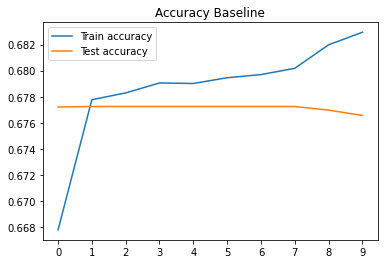

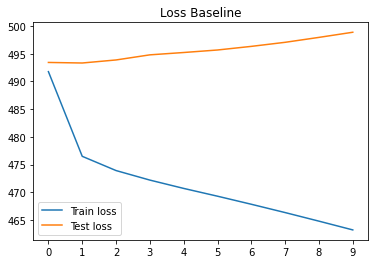

In [ ]:
# Visualization
visualize_acc(train_acc_list, test_acc_list, 'IMDB_figure/baseline_acc.png', 'Accuracy Baseline')
visualize_loss(train_loss_list,test_loss_list, 'IMDB_figure/baseline_loss.png', 'Loss Baseline')

#### Baseline + Glove Embedding

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_glove 
padding_idx = vocabidx['<pad>']

# ------- Train ------
model = Baseline(vocabsize, embed_dim, embed_weight, padding_idx)
modelname = 'baseline_glove.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

train_acc_bl_glove, test_acc_bl_glove, train_loss_bl_glove, test_loss_bl_glove = train(model, optimizer, loss_f, train_data_seq, EPOCH, DEVICE, modelname)
evaluate_baseline(model, modelname, test_data_seq, DEVICE)

epoch 0 : loss 527.5679197907448
Train accuracy: 0.6511683738796414
Test accuracy:  0.6673335467349552
epoch 1 : loss 504.95580726861954
Train accuracy: 0.6662532010243278
Test accuracy:  0.6660131241997439
epoch 2 : loss 488.5357363820076
Train accuracy: 0.662812099871959
Test accuracy:  0.6678137003841229
epoch 3 : loss 480.82928624749184
Train accuracy: 0.6636123559539052
Test accuracy:  0.6712548015364916
epoch 4 : loss 475.8760568201542
Train accuracy: 0.6645326504481434
Test accuracy:  0.6743357874519846
epoch 5 : loss 471.1228320002556
Train accuracy: 0.6674535851472471
Test accuracy:  0.6758162612035852
epoch 6 : loss 465.9586821347475
Train accuracy: 0.6704545454545454
Test accuracy:  0.676816581306018
epoch 7 : loss 460.37270134687424
Train accuracy: 0.6768966069142125
Test accuracy:  0.677336747759283
epoch 8 : loss 454.09923063218594
Train accuracy: 0.6836987836107554
Test accuracy:  0.6776168373879642
epoch 9 : loss 446.4933089017868
Train accuracy: 0.692901728553137
Test 

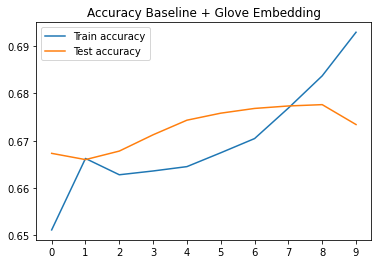

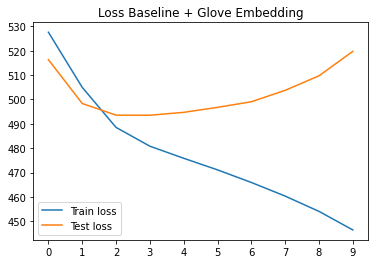

In [ ]:
# Visualization
visualize_acc(train_acc_bl_glove, test_acc_bl_glove, 'IMDB_figure/baseline_glove_acc.png', 'Accuracy Baseline + Glove Embedding')
visualize_loss(train_loss_bl_glove,test_loss_bl_glove, 'IMDB_figure/baseline_glove_loss.png', 'Loss Baseline + Glove Embedding')

#### Baseline + Word2Vec Embedding

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_w2v 
padding_idx = vocabidx['<pad>']

# ------- Train ------
model = Baseline(vocabsize, embed_dim, embed_weight, padding_idx)
modelname = 'baseline_word2vec.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

train_acc_bl_w2v, test_acc_bl_w2v, train_loss_bl_w2v, test_loss_bl_w2v = train(model, optimizer, loss_f, train_data_seq, EPOCH, DEVICE, modelname)
evaluate_baseline(model, modelname, test_data_seq, DEVICE)

epoch 0 : loss 537.644157409668
Train accuracy: 0.6033130601792573
Test accuracy:  0.6394446222791293
epoch 1 : loss 528.817110478878
Train accuracy: 0.6643725992317542
Test accuracy:  0.665132842509603
epoch 2 : loss 515.460407614708
Train accuracy: 0.6545294494238156
Test accuracy:  0.6574903969270166
epoch 3 : loss 499.5942966938019
Train accuracy: 0.6500880281690141
Test accuracy:  0.6591709346991037
epoch 4 : loss 485.95780485868454
Train accuracy: 0.6529289372599232
Test accuracy:  0.6636923815620999
epoch 5 : loss 473.59107092022896
Train accuracy: 0.6648527528809219
Test accuracy:  0.6769366197183099
epoch 6 : loss 452.19471272826195
Train accuracy: 0.6961027528809219
Test accuracy:  0.7103072983354674
epoch 7 : loss 404.7251494526863
Train accuracy: 0.751280409731114
Test accuracy:  0.7542813700384123
epoch 8 : loss 388.03070302307606
Train accuracy: 0.7691661331626121
Test accuracy:  0.6552496798975672
epoch 9 : loss 365.3859012275934
Train accuracy: 0.7836107554417413
Test a

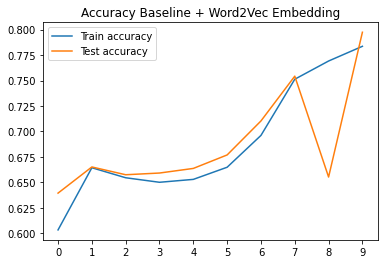

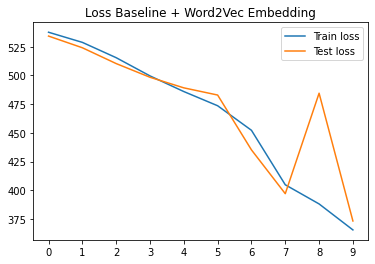

In [ ]:
# Visualization
visualize_acc(train_acc_bl_w2v, test_acc_bl_w2v, 'IMDB_figure/baseline_w2v_acc.png', 'Accuracy Baseline + Word2Vec Embedding')
visualize_loss(train_loss_bl_w2v,test_loss_bl_w2v, 'IMDB_figure/baseline_w2v_loss.png', 'Loss Baseline + Word2Vec Embedding')

## TextCNN

### Model

In [ ]:
class textCNN(torch.nn.Module):
    def __init__(self, vocabsize, embed_dim, embed_weight, padding_idx, dropout_p, n_filter, filter_sizes = [2,3,4]):
        super(textCNN, self).__init__()
        self.vocabsize = vocabsize + 1
        self.embed_dim = embed_dim
        self.embed_weight = embed_weight
        self.padding_idx = padding_idx
        self.filter_sizes = filter_sizes
        self.n_filter = n_filter
        self.dropout_p = dropout_p

        # Embedding layer
        self.emb = torch.nn.Embedding(self.vocabsize, self.embed_dim, padding_idx=self.padding_idx, _weight=self.embed_weight)

        # Convolutional layer
        self.conv_0 = torch.nn.Conv2d(in_channels=1,
                                out_channels=self.n_filter,
                                kernel_size=(self.filter_sizes[0], 300))
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                out_channels=self.n_filter,
                                kernel_size=(self.filter_sizes[1], 300))
        self.conv_2 = torch.nn.Conv2d(in_channels=1,
                                out_channels=self.n_filter,
                                kernel_size=(self.filter_sizes[2], 300))
        # Full connected layer.
        self.fc = torch.nn.Linear(len(self.filter_sizes) * self.n_filter, 2)

        # Drop out to reduce over-fitting.
        self.dropout = torch.nn.Dropout(self.dropout_p)
        
    def forward(self, x):
        x = x.permute(1, 0)

        x = self.emb(x)
        x = x.unsqueeze(1)
        # Conv
        conv_0 = F.relu(self.conv_0(x).squeeze(3))
        conv_1 = F.relu(self.conv_1(x).squeeze(3))
        conv_2 = F.relu(self.conv_2(x).squeeze(3))
        # Pooling
        pooled_0 = F.max_pool1d(conv_0, conv_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conv_1, conv_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conv_2, conv_2.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        h = self.fc(cat)
        return h


In [ ]:
def train(model, optimizer, loss_f, train_data, epochs, device, modelname):
  train_acc_lst = []
  test_acc_lst = []
  train_loss_lst = []
  test_loss_lst = []

  model.to(device)
  for epoch in range(epochs):
    loss = 0
    train_total = 0
    train_correct = 0
    # Training
    model.train()
    for tokenlists, labels in train_data:
      tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
      labels = torch.tensor(labels, dtype=torch.int64).to(device)

      optimizer.zero_grad()
      y = model(tokenlists)
      batchloss = loss_f(y, labels)
      batchloss.backward()
      optimizer.step()
      loss = loss + batchloss.item()

      train_total += len(labels)
      train_correct += (y.max(dim=1)[1] == labels).sum()

    train_acc = train_correct.item()/float(train_total)
    print('epoch', epoch, ": loss", loss)
    print("Train accuracy:", train_acc)

    # Inference
    model.eval()
    test_total = 0
    test_correct = 0
    test_loss = 0
    with torch.no_grad():
      for tokenlists, labels in test_data_seq:
        tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
        labels = torch.tensor(labels, dtype=torch.int64).to(device)
        y = model(tokenlists)
        
        test_batchloss = loss_f(y,labels)
        test_loss += test_batchloss.item()

        test_correct += (y.max(dim=1)[1] == labels).sum()
        test_total += len(labels)

    test_acc = test_correct.item()/float(test_total)
    print("Test accuracy: ", test_acc)

    # Used for visualization
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    train_loss_lst.append(loss)
    test_loss_lst.append(test_loss)

  torch.save(model.state_dict(), modelname)
  return train_acc_lst, test_acc_lst, train_loss_lst, test_loss_lst

In [ ]:
def test(model, modelname, test_data, device):
  total = 0
  correct = 0
  model.to(device)
  model.load_state_dict(torch.load(modelname))
  model.eval()
  for tokenlists, labels in test_data_seq:
    total += len(labels)
    tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    y = model(tokenlists)
    pred_labels = y.max(dim=1)[1]
    correct += (pred_labels == labels).sum()
  acc = correct.item()/float(total)
  print("Accuracy: ", acc)

In [ ]:
def visualize_acc(train_acc, test_acc, name, title):
  x = [i for i in range(10)]
  y1 = [x for x in train_acc]
  y2 = [x for x in test_acc]

  plt.plot(x, y1, label='Train accuracy')
  plt.plot(x, y2, label='Test accuracy')
  plt.xticks([i for i in range(10)])
  plt.title(title)
  
  plt.legend()
  plt.savefig(name)
  plt.show()
  
def visualize_loss(train_loss, test_loss, name, title):
  x = [i for i in range(10)]
  y1 = [x for x in train_loss]
  y2 = [x for x in test_loss]

  plt.plot(x, y1, label='Train loss')
  plt.plot(x, y2, label='Test loss')
  plt.xticks([i for i in range(10)])
  
  plt.title(title)

  plt.legend()
  plt.savefig(name)
  plt.show()

### Training, Evaluation & Visualization

#### TextCNN 

In [ ]:
vocabsize = len(vocabidx)
embed_dim = 300
embed_weight = None 
padding_idx = vocabidx['<pad>']
dropout_p = 0.5
n_filters = 200

# ------- Train ------
model = textCNN(vocabsize, embed_dim, embed_weight, padding_idx, dropout_p, n_filters)
modelname = 'IMDB_model/textcnn.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

train_acc_lst, test_acc_lst, train_loss_lst, test_loss_lst = train(model, optimizer, loss_f, train_data_seq, EPOCH, DEVICE, modelname)
test(model, modelname, test_data_seq, DEVICE)

epoch 0 : loss 662.4511716961861
Train accuracy: 0.5182058258642765
Test accuracy:  0.6314020486555698
epoch 1 : loss 624.1761668920517
Train accuracy: 0.5478953265044815
Test accuracy:  0.6888604353393086
epoch 2 : loss 590.4299156367779
Train accuracy: 0.5758242637644047
Test accuracy:  0.7261123559539052
epoch 3 : loss 554.2172455489635
Train accuracy: 0.6102752880921894
Test accuracy:  0.7579225352112676
epoch 4 : loss 518.7766035497189
Train accuracy: 0.643525928297055
Test accuracy:  0.7837307938540333
epoch 5 : loss 488.9134001135826
Train accuracy: 0.6682938540332907
Test accuracy:  0.8043373879641486
epoch 6 : loss 458.1968975365162
Train accuracy: 0.6998239436619719
Test accuracy:  0.8130601792573624
epoch 7 : loss 434.466254517436
Train accuracy: 0.7201104353393086
Test accuracy:  0.8218229833546735
epoch 8 : loss 416.84762141108513
Train accuracy: 0.735595390524968
Test accuracy:  0.8255441741357235
epoch 9 : loss 396.7505251020193
Train accuracy: 0.7508002560819462
Test ac

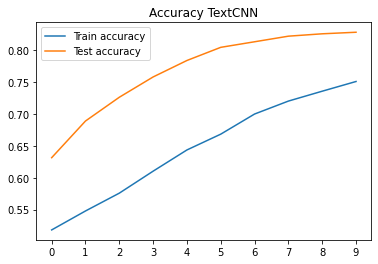

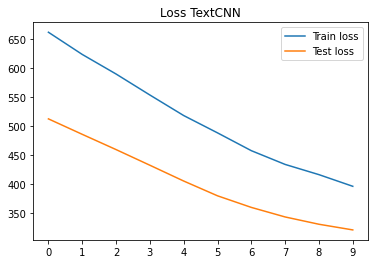

In [ ]:
# Visualization
visualize_acc(train_acc_lst, test_acc_lst, "IMDB_figure/textcnn_acc.png", 'Accuracy TextCNN')
visualize_loss(train_loss_lst, test_loss_lst, "IMDB_figure/textcnn_loss.png", 'Loss TextCNN')

#### TextCNN + Glove

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_glove
padding_idx = vocabidx['<pad>']
dropout_p = 0.5
n_filters = 200

# ------- Train ------
model = textCNN(vocabsize, embed_dim, embed_weight, padding_idx, dropout_p, n_filters)
modelname = 'IMDB_model/textcnn_glove.model' #Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

# start = time.time()
textcnn_train_acc_glove, textcnn_test_acc_glove, textcnn_train_loss_glove, textcnn_test_loss_glove = train(model, optimizer, loss_f, train_data_seq, EPOCH, DEVICE, modelname)
# end = time.time()
test(model, modelname, test_data_seq, DEVICE)
# print("Training Time:", end-start)

epoch 0 : loss 541.3876535892487
Train accuracy: 0.5437740076824584
Test accuracy:  0.636443661971831
epoch 1 : loss 519.8065115809441
Train accuracy: 0.5923495518565941
Test accuracy:  0.6762964148527529
epoch 2 : loss 498.68586111068726
Train accuracy: 0.6402448783610756
Test accuracy:  0.7139484635083226
epoch 3 : loss 474.7004743516445
Train accuracy: 0.6834987195902689
Test accuracy:  0.7521606914212549
epoch 4 : loss 448.0134080648422
Train accuracy: 0.7206706145966709
Test accuracy:  0.7841309218950064
epoch 5 : loss 420.5990568101406
Train accuracy: 0.7535611395646606
Test accuracy:  0.803497119078105
epoch 6 : loss 392.4373385608196
Train accuracy: 0.7854513444302177
Test accuracy:  0.8126200384122919
epoch 7 : loss 369.6864176094532
Train accuracy: 0.8026568501920615
Test accuracy:  0.8220630601792573
epoch 8 : loss 350.4299432337284
Train accuracy: 0.8131402048655569
Test accuracy:  0.8259843149807938
epoch 9 : loss 331.2035351097584
Train accuracy: 0.8261443661971831
Test a

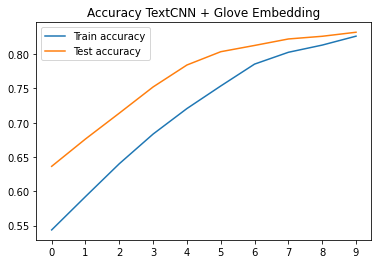

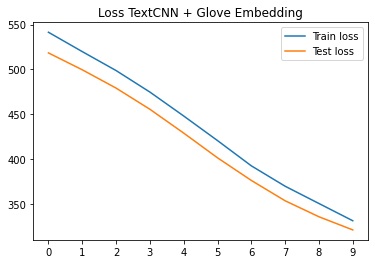

In [ ]:
visualize_acc(textcnn_train_acc_glove, textcnn_test_acc_glove, "IMDB_figure/textcnn_glove_acc.png", "Accuracy TextCNN + Glove Embedding")
visualize_loss(textcnn_train_loss_glove, textcnn_test_loss_glove, "IMDB_figure/textcnn_glove_loss.png", "Loss TextCNN + Glove Embedding")

#### TextCNN + Word2Vec

In [ ]:
# Word2Vec pretrained
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_w2v # Word2vec embedding
padding_idx = vocabidx['<pad>']
dropout_p = 0.5
n_filters = 200

# ------- Train ------
model = textCNN(vocabsize, embed_dim, embed_weight, padding_idx, dropout_p, n_filters)
modelname = 'IMDB_model/textcnn_w2v.model' # Path model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

textcnn_train_acc_w2v, textcnn_test_acc_w2vt, textcnn_train_loss_w2v, textcnn_test_loss_w2v = train(model, optimizer, loss_f, train_data_seq, EPOCH, DEVICE, modelname)
test(model, modelname, test_data_seq, DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0 : loss 537.3618504405022
Train accuracy: 0.5402128681177977
Test accuracy:  0.710387323943662
epoch 1 : loss 521.7948233485222
Train accuracy: 0.6205585787451985
Test accuracy:  0.7558018565941101
epoch 2 : loss 503.41810417175293
Train accuracy: 0.6881802176696543
Test accuracy:  0.7849311779769527
epoch 3 : loss 478.6804048418999
Train accuracy: 0.7450384122919335
Test accuracy:  0.8096991037131882
epoch 4 : loss 447.11856588721275
Train accuracy: 0.7870518565941101
Test accuracy:  0.8228233034571063
epoch 5 : loss 412.67065647244453
Train accuracy: 0.810179257362356
Test accuracy:  0.8285051216389244
epoch 6 : loss 380.09700459241867
Train accuracy: 0.8211027528809219
Test accuracy:  0.8325064020486556
epoch 7 : loss 352.5669922232628
Train accuracy: 0.8289452624839949
Test accuracy:  0.8349871959026889
epoch 8 : loss 329.70979857444763
Train accuracy: 0.8356674135723432
Test accuracy:  0.8380281690140845
epoch 9 : loss 314.3311844319105
Train accuracy: 0.840789052496799
Tes

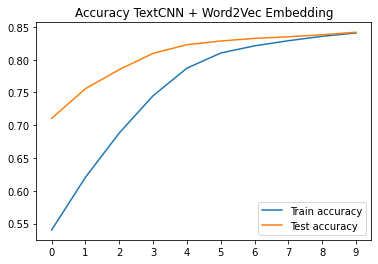

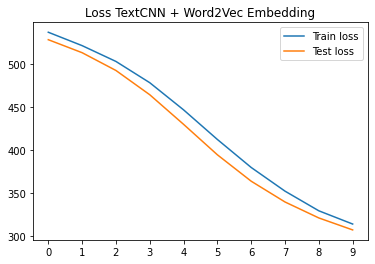

In [ ]:
# Visualization 
visualize_acc(textcnn_train_acc_w2v, textcnn_test_acc_w2vt, "IMDB_figure/textcnn_w2v_acc.png", "Accuracy TextCNN + Word2Vec Embedding")
visualize_loss(textcnn_train_loss_w2v, textcnn_test_loss_w2v, "IMDB_figure/textcnn_w2v_loss.png", "Loss TextCNN + Word2Vec Embedding")

## LSTM

### Model

In [ ]:
class LSTM(nn.Module):
  def __init__(self,  vocab_size, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p, bidirectional =False):
    super(LSTM,self).__init__()
    self.embed_dim = embed_dim
    self.hidden_dim = hidden_dim
    self.embed_weight = embed_weight
    self.padding_idx = padding_idx
    self.n_layers = n_layers
    self.vocab_size = vocab_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.n_directions = 1
    self.bidirectional  = bidirectional 
    if self.bidirectional :
      self.n_directions = 2 

    # embedding and LSTM layers
    self.embedding = torch.nn.Embedding(self.vocab_size, self.embed_dim, padding_idx=self.padding_idx, _weight=self.embed_weight)
    
    # LSTM layer
    self.lstm = nn.LSTM(input_size=self.embed_dim,hidden_size=self.hidden_dim, bidirectional  = self.bidirectional ,
                        num_layers=self.n_layers, batch_first=True, dropout=((0 if self.n_layers == 1 else self.dropout_p)))
    
    # Drop-out layer
    self.dropout = nn.Dropout(self.dropout_p)

    # linear layer
    self.fc = nn.Linear(self.hidden_dim*self.n_directions , self.output_size)
        
  def forward(self,x, hidden):
    batch_size = x.size(1)
    embeds = self.embedding(x).permute(1,0,2)
    lstm_out, hidden = self.lstm(embeds, hidden)
    out = self.dropout(lstm_out)
    out = self.fc(out)
    return F.log_softmax(out[:,-1], dim=-1)

  def init_hidden(self, batch_size):
      ''' Initializes hidden state '''
      h0 = torch.zeros((self.n_layers*self.n_directions,batch_size,self.hidden_dim)).to(DEVICE)
      c0 = torch.zeros((self.n_layers*self.n_directions,batch_size,self.hidden_dim)).to(DEVICE)
      hidden = (h0,c0)
      return hidden

In [ ]:
def train(model, optimizer, loss_f, train_data, test_data, epochs, device, modelname, batchsize):
  train_acc_lst = []
  test_acc_lst = []
  train_loss_lst = []
  test_loss_lst = []

  model.to(device)
  for epoch in range(epochs):
    # Training
    loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for tokenlists, labels in train_data:
      tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
      labels = torch.tensor(labels, dtype=torch.int64).to(device)

      optimizer.zero_grad()
      hidden = model.init_hidden(batchsize) # Init hidden state
      y = model(tokenlists, hidden)
      batchloss = loss_f(y, labels)
      batchloss.backward()
      optimizer.step()
      loss = loss + batchloss.item()

      train_total += len(labels)
      train_correct += (y.max(dim=1)[1] == labels).sum()

    train_acc = train_correct.item()/float(train_total)
    print('epoch', epoch, ": loss", loss)
    print("Train accuracy:", train_acc)

    # Inference
    model.eval()
    test_total = 0
    test_correct = 0
    test_loss = 0
    hidden = model.init_hidden(batchsize)
    with torch.no_grad():
      for tokenlists, labels in test_data:
        tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
        labels = torch.tensor(labels, dtype=torch.int64).to(device)
        y = model(tokenlists, hidden)
        
        test_batchloss = loss_f(y,labels)
        test_loss += test_batchloss.item()

        test_correct += (y.max(dim=1)[1] == labels).sum()
        test_total += len(labels)

    test_acc = test_correct.item()/float(test_total)
    print("Test accuracy: ", test_acc)

    # Used for visualization
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    train_loss_lst.append(loss)
    test_loss_lst.append(test_loss)

  torch.save(model.state_dict(), modelname)
  return train_acc_lst, test_acc_lst, train_loss_lst, test_loss_lst

In [ ]:
def test(model, modelname, test_data, device, batchsize):
  total = 0
  correct = 0
  model.to(device)
  model.load_state_dict(torch.load(modelname))
  model.eval()
  hidden = model.init_hidden(batchsize)
  for tokenlists, labels in test_data_seq:
    total += len(labels)
    tokenlists = torch.tensor(tokenlists, dtype=torch.int64).transpose(0,1).to(device)
    labels = torch.tensor(labels, dtype=torch.int64).to(device)
    y = model(tokenlists, hidden)
    pred_labels = y.max(dim=1)[1]
    correct += (pred_labels == labels).sum()
  acc = correct.item()/float(total)
  print("Accuracy: ", acc)

  return acc

In [ ]:
# Visualize function
def visualize_acc(train_acc, test_acc, name, title):
  x = [i for i in range(10)]
  y1 = [x for x in train_acc]
  y2 = [x for x in test_acc]

  plt.plot(x, y1, label='Train accuracy')
  plt.plot(x, y2, label='Test accuracy')
  plt.xticks([i for i in range(10)])
  plt.title(title)
  
  plt.legend()
  plt.savefig(name)
  plt.show()
  
def visualize_loss(train_loss, test_loss, name, title):
  x = [i for i in range(10)]
  y1 = [x for x in train_loss]
  y2 = [x for x in test_loss]

  plt.plot(x, y1, label='Train loss')
  plt.plot(x, y2, label='Test loss')
  plt.xticks([i for i in range(10)])
  
  plt.title(title)

  plt.legend()
  plt.savefig(name)
  plt.show()

###Training, Evaluation & Visualization LSTM

#### LSTM

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = None # No embedding weight

bidirectional = False # If True, Bi-LSTM model

padding_idx = vocabidx['<pad>']
hidden_dim = 300
dropout_p = 0.5
n_layers = 2
output_size = 2

# ------- Train ------
model = LSTM(vocabsize, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p)
modelname = 'IMDB_model/lstm.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

lstm_train_acc_lst, lstm_test_acc_lst, lstm_train_loss_lst, lstm_test_loss_lst = train(model, optimizer, loss_f, train_data_seq, test_data_seq, EPOCH, DEVICE, modelname, BATCHSIZE)
test(model, modelname, test_data_seq, DEVICE, BATCHSIZE)

epoch 0 : loss 535.3913739919662
Train accuracy: 0.5949903969270166
Test accuracy:  0.6662131882202305
epoch 1 : loss 509.843335300684
Train accuracy: 0.6645326504481434
Test accuracy:  0.670014404609475
epoch 2 : loss 473.71028646826744
Train accuracy: 0.6798975672215108
Test accuracy:  0.6204785531370038
epoch 3 : loss 454.15321815013885
Train accuracy: 0.6957426376440461
Test accuracy:  0.5935899487836107
epoch 4 : loss 415.69389951229095
Train accuracy: 0.7335547375160051
Test accuracy:  0.6868597951344431
epoch 5 : loss 360.81431936472654
Train accuracy: 0.7830105633802817
Test accuracy:  0.6886603713188221
epoch 6 : loss 334.59040919691324
Train accuracy: 0.804137323943662
Test accuracy:  0.7003441101152369
epoch 7 : loss 318.2823516242206
Train accuracy: 0.816741357234315
Test accuracy:  0.7920534571062741
epoch 8 : loss 302.8334666490555
Train accuracy: 0.8284250960307298
Test accuracy:  0.774687900128041
epoch 9 : loss 292.8187408782542
Train accuracy: 0.8363076184379001
Test 

0.7942541613316261

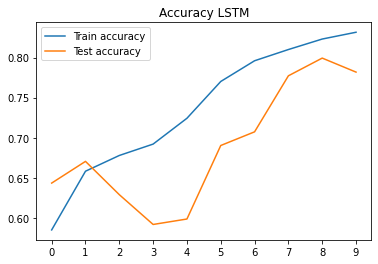

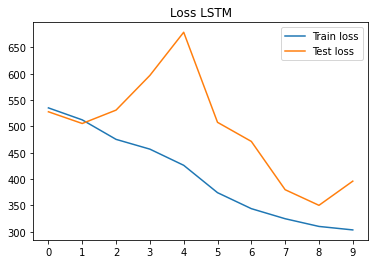

In [ ]:
# Visualize
visualize_acc(lstm_train_acc_lst, lstm_test_acc_lst, "IMDB_figure/lstm_acc.png", 'Accuracy LSTM')
visualize_loss(lstm_train_loss_lst, lstm_test_loss_lst, "IMDB_figure/lstm_loss.png", 'Loss LSTM')

#### LSTM + Glove Embedding

In [ ]:
inputsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_glove 
padding_idx = vocabidx['<pad>']
hidden_dim = 300
dropout_p = 0.5
n_layers = 2
output_size = 2

# ------- Train ------
model = LSTM(inputsize, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p)
modelname = 'IMDB_model/lstm_glove.model'
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

lstm_train_acc_glove, lstm_test_acc_glove, lstm_train_loss_glove, lstm_test_loss_glove = train(model, optimizer, loss_f, train_data_seq, test_data_seq, EPOCH, DEVICE, modelname, BATCHSIZE)
test(model, modelname, test_data_seq, DEVICE, BATCHSIZE)

epoch 0 : loss 539.2682730555534
Train accuracy: 0.5511363636363636
Test accuracy:  0.5713428297055058
epoch 1 : loss 530.6408226490021
Train accuracy: 0.6063940460947503
Test accuracy:  0.6494078104993598
epoch 2 : loss 413.20156325399876
Train accuracy: 0.7432778489116517
Test accuracy:  0.7753281049935979
epoch 3 : loss 362.73217974603176
Train accuracy: 0.7886523687580026
Test accuracy:  0.7841309218950064
epoch 4 : loss 343.7884595692158
Train accuracy: 0.8033370678617158
Test accuracy:  0.7924135723431498
epoch 5 : loss 330.76727426052094
Train accuracy: 0.81354033290653
Test accuracy:  0.7876920614596671
epoch 6 : loss 325.75928327441216
Train accuracy: 0.8161411651728553
Test accuracy:  0.797455185659411
epoch 7 : loss 312.4498875439167
Train accuracy: 0.8264244558258643
Test accuracy:  0.8111795774647887
epoch 8 : loss 298.8358050212264
Train accuracy: 0.8367877720870679
Test accuracy:  0.7978553137003841
epoch 9 : loss 291.0222783088684
Train accuracy: 0.8406290012804097
Test

0.7955345710627401

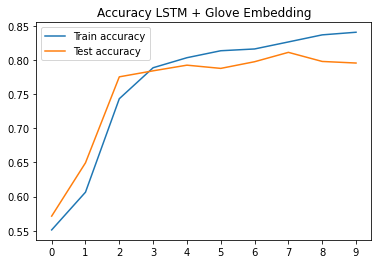

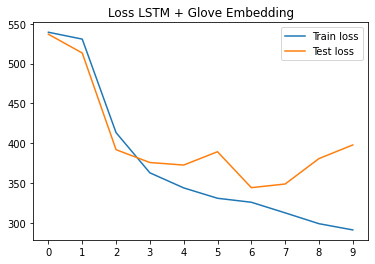

In [ ]:
visualize_acc(lstm_train_acc_glove, lstm_test_acc_glove, "IMDB_figure/lstm_glove_acc.png", 'Accuracy LSTM + Glove Embedding')
visualize_loss(lstm_train_loss_glove, lstm_test_loss_glove, "IMDB_figure/lstm_glove_loss.png", 'Loss LSTM + Glove Embedding')

#### LSTM + Word2Vec Embedding

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_w2v 
padding_idx = vocabidx['<pad>']
hidden_dim = 300
dropout_p = 0.5
n_layers = 2
output_size = 2

# ------- Train ------
model = LSTM(vocabsize, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p)
modelname = 'IMDB_model/lstm.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

lstm_train_acc_w2v, lstm_test_acc_w2v, lstm_train_loss_w2v, lstm_test_loss_w2v = train(model, optimizer, loss_f, train_data_seq, test_data_seq, EPOCH, DEVICE, modelname, BATCHSIZE)
test(model, modelname, test_data_seq, DEVICE, BATCHSIZE)

epoch 0 : loss 540.8118460774422
Train accuracy: 0.5262483994878361
Test accuracy:  0.6296014724711908
epoch 1 : loss 535.8953277468681
Train accuracy: 0.5905089628681178
Test accuracy:  0.604673495518566
epoch 2 : loss 383.3760461062193
Train accuracy: 0.7711667733674776
Test accuracy:  0.8125400128040973
epoch 3 : loss 301.42585450410843
Train accuracy: 0.8343069782330346
Test accuracy:  0.8322263124199744
epoch 4 : loss 277.21544052660465
Train accuracy: 0.8501520486555698
Test accuracy:  0.8379081306017926
epoch 5 : loss 261.0501924082637
Train accuracy: 0.8604353393085787
Test accuracy:  0.8452304737516005
epoch 6 : loss 247.4279162287712
Train accuracy: 0.8692381562099872
Test accuracy:  0.8524727912932138
epoch 7 : loss 235.28653994947672
Train accuracy: 0.8770806658130602
Test accuracy:  0.8580345710627401
epoch 8 : loss 223.94126475602388
Train accuracy: 0.884122919334187
Test accuracy:  0.8613156209987196
epoch 9 : loss 213.90815667435527
Train accuracy: 0.8906450064020487
Te

0.8604353393085787

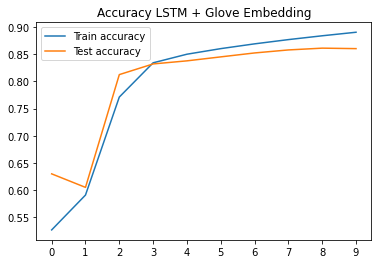

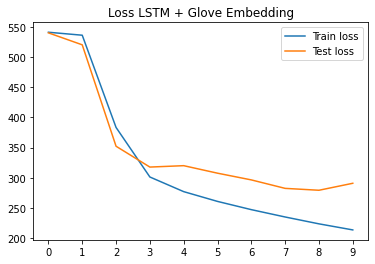

In [ ]:
# Visualize
visualize_acc(lstm_train_acc_w2v, lstm_test_acc_w2v, "IMDB_figure/lstm_w2v_acc.png", 'Accuracy LSTM + Glove Embedding')
visualize_loss(lstm_train_loss_w2v, lstm_test_loss_w2v, "IMDB_figure/lstm_w2v_loss.png", 'Loss LSTM + Glove Embedding')

###Training, Evaluation & Visualization Bi-LSTM

#### Bi-LSTM

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = None 
padding_idx = vocabidx['<pad>']
hidden_dim = 300
dropout_p = 0.5
n_layers = 5
output_size = 2
bidirectional = True

# ------- Train ------
model = LSTM(vocabsize, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p, bidirectional)
modelname = 'IMDB_model/lstm.model' # Path save model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

lstm_train_acc_lst, lstm_test_acc_lst, lstm_train_loss_lst, lstm_test_loss_lst = train(model, optimizer, loss_f, train_data_seq, test_data_seq, EPOCH, DEVICE, modelname, BATCHSIZE)
test(model, modelname, test_data_seq, DEVICE, BATCHSIZE)

epoch 0 : loss 540.9015198349953
Train accuracy: 0.5201664532650448
Test accuracy:  0.6041133162612036
epoch 1 : loss 496.913099616766
Train accuracy: 0.6438460307298336
Test accuracy:  0.543854033290653
epoch 2 : loss 435.361058332026
Train accuracy: 0.7131482074263764
Test accuracy:  0.5345310499359796
epoch 3 : loss 410.8992487117648
Train accuracy: 0.740997119078105
Test accuracy:  0.5783850832266325
epoch 4 : loss 371.6188082024455
Train accuracy: 0.7718469910371318
Test accuracy:  0.6866997439180538
epoch 5 : loss 348.1700405329466
Train accuracy: 0.7882122279129321
Test accuracy:  0.7584827144686299
epoch 6 : loss 341.7939480766654
Train accuracy: 0.7870118437900128
Test accuracy:  0.62976152368758
epoch 7 : loss 390.50324679911137
Train accuracy: 0.7564420614596671
Test accuracy:  0.6465669014084507
epoch 8 : loss 318.11795703694224
Train accuracy: 0.8150608194622279
Test accuracy:  0.778809218950064
epoch 9 : loss 308.16072913631797
Train accuracy: 0.8213028169014085
Test accu

0.7936139564660691

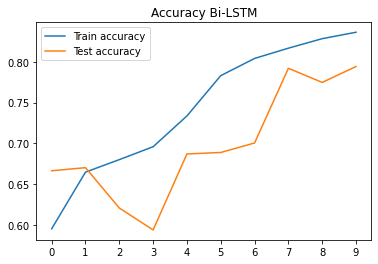

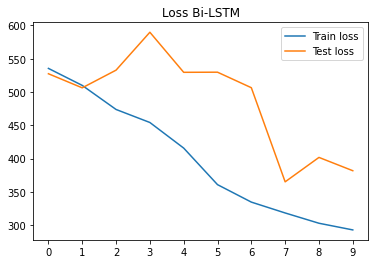

In [ ]:
# Visualization
visualize_acc(lstm_train_acc_lst, lstm_test_acc_lst, "IMDB_figure/bilstm_acc.png", 'Accuracy Bi-LSTM')
visualize_loss(lstm_train_loss_lst, lstm_test_loss_lst, "IMDB_figure/bilstm_loss.png", 'Loss Bi-LSTM')

#### Bi-LSTM + Glove Embedding

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_glove 
padding_idx = vocabidx['<pad>']
hidden_dim = 300
dropout_p = 0.5
n_layers = 5
output_size = 2
bidirectional = True

# ------- Train ------
model = LSTM(vocabsize, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p)
modelname = 'IMDB_model/bilstm_glove2.model'
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

lstm_train_acc_glove, lstm_test_acc_glove, lstm_train_loss_glove, lstm_test_loss_glove = train(model, optimizer, loss_f, train_data_seq, test_data_seq, EPOCH, DEVICE, modelname, BATCHSIZE)
test(model, modelname, test_data_seq, DEVICE, BATCHSIZE)

epoch 0 : loss 541.5464833974838
Train accuracy: 0.5032010243277849
Test accuracy:  0.4998799615877081
epoch 1 : loss 524.624005317688
Train accuracy: 0.5768245838668374
Test accuracy:  0.7210307298335468
epoch 2 : loss 382.87907695770264
Train accuracy: 0.7736875800256082
Test accuracy:  0.7870518565941101
epoch 3 : loss 352.4933776855469
Train accuracy: 0.7993758002560819
Test accuracy:  0.7992157490396927
epoch 4 : loss 337.5297859609127
Train accuracy: 0.8113796414852753
Test accuracy:  0.7978553137003841
epoch 5 : loss 325.372729241848
Train accuracy: 0.8192221510883483
Test accuracy:  0.8158210627400768
epoch 6 : loss 311.205804631114
Train accuracy: 0.8303056978233034
Test accuracy:  0.81145966709347
epoch 7 : loss 300.90581837296486
Train accuracy: 0.837067861715749
Test accuracy:  0.8168613956466069
epoch 8 : loss 290.2547375559807
Train accuracy: 0.8439500640204866
Test accuracy:  0.8131802176696543
epoch 9 : loss 281.2824099957943
Train accuracy: 0.8495918693982074
Test accu

0.8120598591549296

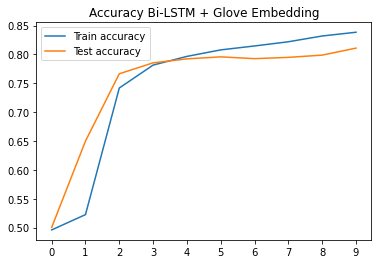

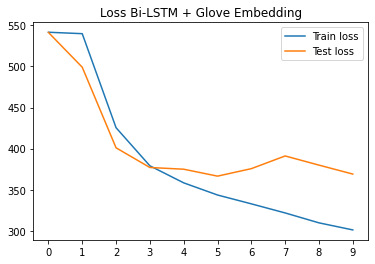

In [ ]:
visualize_acc(lstm_train_acc_glove, lstm_test_acc_glove, "IMDB_figure/bilstm_glove_acc.png", 'Accuracy Bi-LSTM + Glove Embedding')
visualize_loss(lstm_train_loss_glove, lstm_test_loss_glove, "IMDB_figure/bilstm_glove_loss.png", 'Loss Bi-LSTM + Glove Embedding')

#### Bi-LSTM + Word2Vec Embedding

In [ ]:
vocabsize = len(vocabidx) + 1
embed_dim = 300
embed_weight = weight_w2v 
padding_idx = vocabidx['<pad>']
hidden_dim = 300
dropout_p = 0.5
n_layers = 5
output_size = 2
bidirectional = True

# ------- Train ------
model = LSTM(vocabsize, embed_dim, embed_weight, padding_idx, hidden_dim, n_layers, output_size, dropout_p)
modelname = '/content/drive/MyDrive/IE229_AI/IMDB/Model/bilstm_w2v.model'
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_f = nn.CrossEntropyLoss()

lstm_train_acc_w2v, lstm_test_acc_w2v, lstm_train_loss_w2v, lstm_test_loss_w2v = train(model, optimizer, loss_f, train_data_seq, test_data_seq, EPOCH, DEVICE, modelname, BATCHSIZE)
test(model, modelname, test_data_seq, DEVICE, BATCHSIZE)

epoch 0 : loss 541.5029240846634
Train accuracy: 0.49827944942381563
Test accuracy:  0.4998799615877081
epoch 1 : loss 541.3702020645142
Train accuracy: 0.5000800256081946
Test accuracy:  0.5179257362355953
epoch 2 : loss 497.1723054945469
Train accuracy: 0.6244398207426376
Test accuracy:  0.7692461587708067
epoch 3 : loss 372.70978306233883
Train accuracy: 0.7830905889884763
Test accuracy:  0.7269926376440461
epoch 4 : loss 332.7691060304642
Train accuracy: 0.8218629961587708
Test accuracy:  0.822143085787452
epoch 5 : loss 291.99726728349924
Train accuracy: 0.844270166453265
Test accuracy:  0.8373879641485276
epoch 6 : loss 274.48185481876135
Train accuracy: 0.8551136363636364
Test accuracy:  0.8429097311139565
epoch 7 : loss 263.1017179861665
Train accuracy: 0.8617157490396927
Test accuracy:  0.805297695262484
epoch 8 : loss 252.9022139236331
Train accuracy: 0.8692381562099872
Test accuracy:  0.8499119718309859
epoch 9 : loss 240.18632915616035
Train accuracy: 0.8760803457106274
Tes

0.8575944302176697

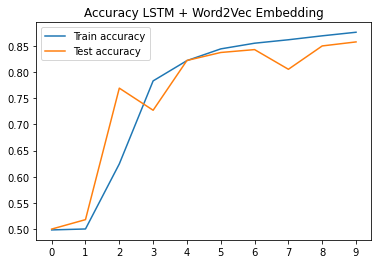

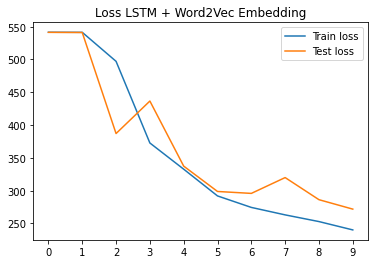

In [ ]:
visualize_acc(lstm_train_acc_w2v, lstm_test_acc_w2v, "IMDB_figure/bilstm_w2v_acc.png", 'Accuracy LSTM + Word2Vec Embedding')
visualize_loss(lstm_train_loss_w2v, lstm_test_loss_w2v, "IMDB_figure/bilstm_w2v_loss.png", 'Loss LSTM + Word2Vec Embedding')